
 Analyzing frequency spectrum...


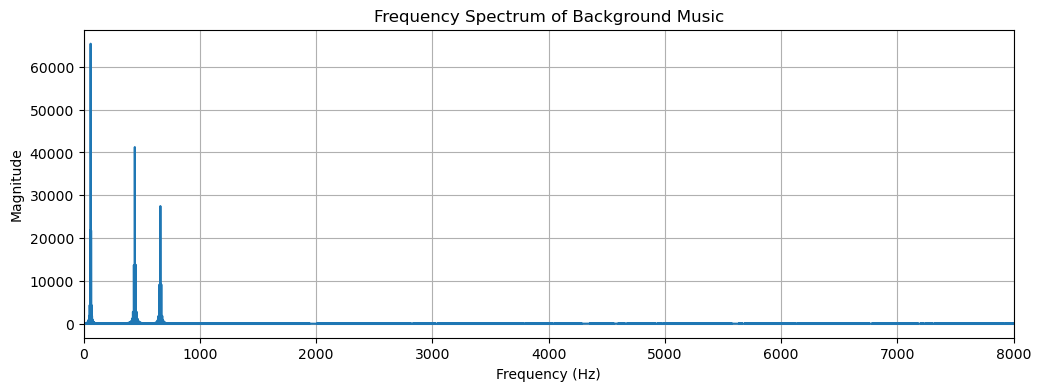

Sample Rate: 44100 Hz
Duration: 10.00 seconds

 Designing bandpass filters...

 Applying filters and saving separated tracks...
Saved: separated_Band_1_80-250Hz.wav
Saved: separated_Band_2_250-2000Hz.wav
Saved: separated_Band_3_2000-8000Hz.wav


In [11]:
#----phase1: the spectral splitter(flitring)----
import numpy as np
import scipy.io.wavfile as wavfile
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

def analyze_frequency_spectrum(audio_file):
    sample_rate, data = wavfile.read(audio_file)

    if len(data.shape) > 1:
        data = np.mean(data, axis=1)

    data = data / np.max(np.abs(data))

    # Compute FFT
    N = len(data)
    yf = fft(data)
    xf = fftfreq(N, 1/sample_rate)

    positive_freq_idx = xf > 0
    xf = xf[positive_freq_idx]
    yf = np.abs(yf[positive_freq_idx])

    # Plot frequency spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(xf, yf)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of Background Music')
    plt.grid(True)
    plt.xlim(0, min(8000, sample_rate/2))
    plt.savefig('frequency_spectrum.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Sample Rate: {sample_rate} Hz")
    print(f"Duration: {len(data)/sample_rate:.2f} seconds")

    return sample_rate, data

def design_bandpass_filters(sample_rate):
    filters = []
    bands = [
        (80, 250),      # Low frequencies (bass, drums)
        (250, 2000),    # Mid frequencies (vocals, guitars)
        (2000, 8000)    # High frequencies (cymbals, high-hats)
    ]

    for i, (low, high) in enumerate(bands):
        nyquist = sample_rate / 2
        low_norm = low / nyquist
        high_norm = high / nyquist
        sos = signal.butter(5, [low_norm, high_norm], btype='band', output='sos')
        filters.append({'sos': sos, 'name': f'Band_{i+1}_{low}-{high}Hz'})

    return filters

def apply_filters_and_save(data, filters, sample_rate):
    for filt in filters:
        filtered = signal.sosfilt(filt['sos'], data)
        normalized = filtered / np.max(np.abs(filtered))
        audio_data = (normalized * 32767).astype(np.int16)
        filename = f"separated_{filt['name']}.wav"
        wavfile.write(filename, sample_rate, audio_data)
        print(f"Saved: {filename}")


try:
    print("\n Analyzing frequency spectrum...")
    sr, audio_data = analyze_frequency_spectrum('Student_Data_Pack/mixed_background.wav')

    print("\n Designing bandpass filters...")
    filters = design_bandpass_filters(sr)

    print("\n Applying filters and saving separated tracks...")
    apply_filters_and_save(audio_data, filters, sr)

except FileNotFoundError:
    print("\n⚠ Error: 'mixed_background.wav' not found!")

In [12]:
#----phase2: the cocktail party(ica)----
from sklearn.decomposition import FastICA

def load_mic_recordings(mic1_file, mic2_file):
    sr1, mic1 = wavfile.read(mic1_file)
    sr2, mic2 = wavfile.read(mic2_file)

    if sr1 != sr2:
        raise ValueError("Sample rates must match!")

    if len(mic1.shape) > 1:
        mic1 = np.mean(mic1, axis=1)
    if len(mic2.shape) > 1:
        mic2 = np.mean(mic2, axis=1)

    mic1 = mic1 / np.max(np.abs(mic1))
    mic2 = mic2 / np.max(np.abs(mic2))

    min_len = min(len(mic1), len(mic2))
    mic1 = mic1[:min_len]
    mic2 = mic2[:min_len]

    return sr1, mic1, mic2

def perform_ica_separation(mic1, mic2):
    X = np.c_[mic1, mic2]
    ica = FastICA(n_components=2, random_state=42, max_iter=1000)
    S = ica.fit_transform(X)
    return S[:, 0], S[:, 1]

def identify_voice_and_save(source_1, source_2, sample_rate):
    def voice_score(sig, sr):
        f, psd = signal.welch(sig, sr, nperseg=2048)
        voice_range = (f >= 300) & (f <= 3400)
        return np.sum(psd[voice_range]) / np.sum(psd)

    score_1 = voice_score(source_1, sample_rate)
    score_2 = voice_score(source_2, sample_rate)

    print(f"Source 1 voice score: {score_1:.4f}")
    print(f"Source 2 voice score: {score_2:.4f}")

    if score_1 > score_2:
        voice, music = source_1, source_2
        print("Source 1 identified as VOICE")
    else:
        voice, music = source_2, source_1
        print("Source 2 identified as VOICE")

    # Save results
    voice_norm = (voice / np.max(np.abs(voice)) * 32767).astype(np.int16)
    music_norm = (music / np.max(np.abs(music)) * 32767).astype(np.int16)

    wavfile.write('separated_voice.wav', sample_rate, voice_norm)
    wavfile.write('separated_music.wav', sample_rate, music_norm)

    print("\nSaved: separated_voice.wav")
    print("Saved: separated_music.wav")

try:
    print("\n Loading microphone recordings...")
    sr, mic1, mic2 = load_mic_recordings('Student_Data_Pack/mic_1.wav', 'Student_Data_Pack/mic_2.wav')
    print(f"Loaded: {len(mic1)} samples at {sr} Hz")

    print("\n  Performing ICA separation...")
    source_1, source_2 = perform_ica_separation(mic1, mic2)

    print("\n Identifying voice and saving...")
    identify_voice_and_save(source_1, source_2, sr)

except FileNotFoundError:
    print("\n⚠ Error: 'mic_1.wav' and 'mic_2.wav' not found!")


 Loading microphone recordings...
Loaded: 441000 samples at 44100 Hz

  Performing ICA separation...

 Identifying voice and saving...
Source 1 voice score: 0.3611
Source 2 voice score: 0.5768
Source 2 identified as VOICE

Saved: separated_voice.wav
Saved: separated_music.wav


In [13]:
#----Phase 2B: The Clean-Up (Post-Processing)----
def apply_cleanup_filter(voice_file):
    sr, data = wavfile.read(voice_file)

    # High-Pass filter to remove low-frequency "rumble" (< 80Hz)
    sos = signal.butter(4, 80, 'hp', fs=sr, output='sos')
    
    clean_voice = signal.sosfilt(sos, data)

    clean_voice = clean_voice / np.max(np.abs(clean_voice))
    audio_data = (clean_voice * 32767).astype(np.int16)
    
    output_filename = 'clean_voice.wav'
    wavfile.write(output_filename, sr, audio_data)
    
    print(f"Saved: {output_filename}")
    return output_filename, sr, clean_voice

try:
    print("\n--- Phase 2B: Cleaning up the voice signal ---")
    clean_filename, sr, clean_data = apply_cleanup_filter('separated_voice.wav')
    
except FileNotFoundError:
    print("\n⚠ Error: 'separated_voice.wav' not found! Make sure Phase 2 ran successfully.")


--- Phase 2B: Cleaning up the voice signal ---
Saved: clean_voice.wav


In [14]:
#----Phase 3: The Bit-Crusher (Wavelet Compression)----
import pywt

def compress_audio_wavelet(audio_data, sample_rate, compression_percent=20):
   
    coeffs = pywt.wavedec(audio_data, 'db4', level=5) #decomposition
    
    coeffs_flat = np.hstack(coeffs) #horizontal stack (collection/flatten)

    sorted_coeffs = np.sort(np.abs(coeffs_flat))

    cut_index = int(len(sorted_coeffs) * (1 - compression_percent/100))
    threshold = sorted_coeffs[cut_index]
    
    print(f"Thresholding: Keeping top {compression_percent}% coefficients > {threshold:.4f}")
    

    coeffs_thresholded = []
    non_zero_count = 0
    total_count = 0
    
    for c in coeffs:
        c_thresh = np.where(np.abs(c) > threshold, c, 0)
        coeffs_thresholded.append(c_thresh)
        
        non_zero_count += np.count_nonzero(c_thresh)
        total_count += c.size
        
    reconstructed_signal = pywt.waverec(coeffs_thresholded, 'db4')
    
    if len(reconstructed_signal) > len(audio_data):
        reconstructed_signal = reconstructed_signal[:len(audio_data)]
    
    compression_ratio = total_count / non_zero_count if non_zero_count > 0 else 0
    print(f"Compression Ratio (Coefficients): {compression_ratio:.2f} : 1")
    
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))
    audio_int16 = (reconstructed_signal * 32767).astype(np.int16)
    
    output_filename = 'compressed_voice.wav'
    wavfile.write(output_filename, sample_rate, audio_int16)
    print(f"Saved: {output_filename}")

try:
    print("\n--- Phase 3: Wavelet Compression ---")
    compress_audio_wavelet(clean_data, sr, compression_percent=20)
    
except NameError:
    print("\n⚠ Error: Clean voice data not found in memory.")
except Exception as e:
    print(f"\n⚠ Error in compression: {e}")


--- Phase 3: Wavelet Compression ---
Thresholding: Keeping top 20% coefficients > 0.0032
Compression Ratio (Coefficients): 5.00 : 1
Saved: compressed_voice.wav
